# Домашнее задание 3

1) [1 балл] Реализуйте чтение изображений, лежащих в /data/imgs/arrow (как в демо с калибровкой камеры с семинара). Вся обязательная часть задания выполняется с этими изображениями

1) [2 балла] Реализуйте нахождение расстояния от камеры до листка, учитывая, что это тот же листок, что был в первом демо

2) [3 балла] Реализуйте приведение изображения листка к "виду сверху"

3) [6 баллов] Реализуйте определение направления, в котором указывает стрелка. Можно использовать скелетонизацию из первого семинара по зрению: получить маску темной области (стрелки) внутри изображения листка, применить скелетонизацию, вычислить направление. Можно поступить иначе: после нахождения маски вычислить градиенты Собеля по x и y и проанализировать их направления. P.S. Можно использовать и полностью свой метод

4) [3 балла] Доп. задача 1: Примените написанный Вами код к видео https://drive.google.com/file/d/1AQhg2lL5FL4edlOcxY2SHOOZ-v9TgHBD/view?usp=sharing. Загрузите видео на свой гугл диск, а затем дополните имеющийся код монтированием диска и чтением в цикле кадров видео, приведёнными в конце семинара

5) [5 баллов] Доп. задача 2: определите, нормально ли видно листок в кадре. На некоторых кадрах его видно не полностью, один или больше уголков находятся за кадром. Это можно автоматически обнаруживать, к примеру используя размеры стрелки, и выводить на соответствующем кадре маркер - текст или цветную метку

# Загрузка изображений

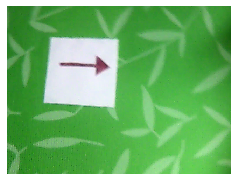

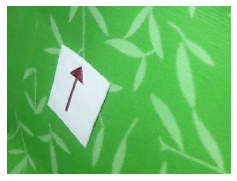

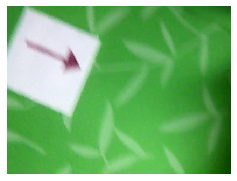

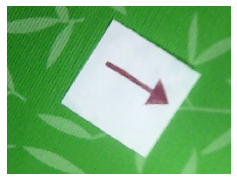

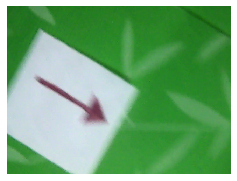

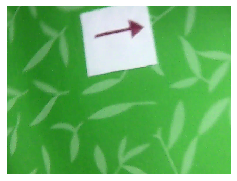

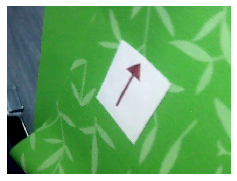

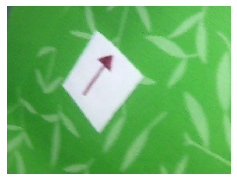

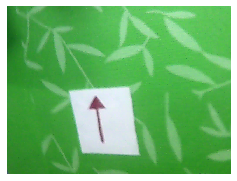

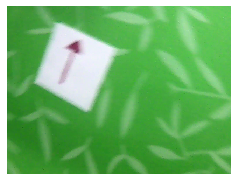

In [5]:
import numpy as np
import cv2
import time
import os
import math
import glob
import sys
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (4,4)

images = glob.glob('../data/imgs/arrow/*.png')

for f in images:
    img = cv2.imread(f)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

# Приведение к виду сверху

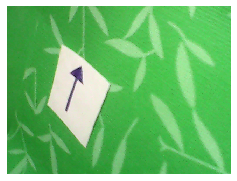

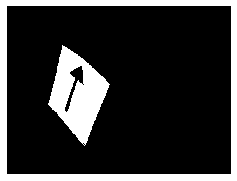

In [35]:
img = cv2.imread('../data/imgs/arrow/vlcsnap-2020-10-21-18h01m22s212.png', cv2.IMREAD_COLOR)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img_rgb)
plt.axis('off')
plt.show()

low_th  = (190, 190, 190)
high_th = (255, 255, 255)

mask = cv2.inRange(img, low_th, high_th)

res = np.ones(img_rgb.shape, dtype="float32")
re = cv2.bitwise_and(res, res, mask=mask)


plt.imshow(re)
plt.axis('off')
plt.show()

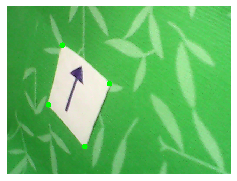

In [7]:
contours, hierarchy = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours = [c for c in contours if cv2.arcLength(c, True) > 100]
cnt = contours[0]

approx = cv2.convexHull(cnt)

epsilon = 0.05 * cv2.arcLength(approx, True)

approx = cv2.approxPolyDP(approx, epsilon, True)

contour_marked = cv2.drawContours(img_rgb, approx, -1, (0, 255, 0), 15)

plt.imshow(contour_marked)
plt.axis('off')
plt.show()

In [8]:
from scipy.spatial import distance as dist
def order_points(pts):
    x_sorted = pts[np.argsort(pts[:, 0]), :]
    
    left_most = x_sorted[:2, :]
    right_most = x_sorted[2:, :]
    
    left_most = left_most[np.argsort(left_most[:, 1]), :]
    tl, bl = left_most
    
    d = dist.cdist(tl[np.newaxis], right_most, "euclidean")[0]
    br, tr = right_most[np.argsort(d)[::-1], :]
    
    return np.array([tl, tr, br, bl], dtype="float32")

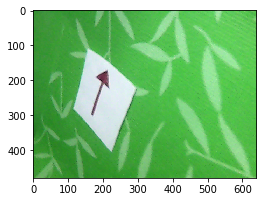

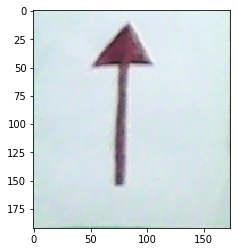

In [9]:
def four_point_transform(image, pts):
    rect = order_points(pts)
    (tl, tr, br, bl) = rect

    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))

    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))

    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype="float32")
    
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
    
    return warped

warped = four_point_transform(img, np.asarray(approx)[:, 0, :])

plt.imshow(img)
# plt.axis('off')
plt.show()

plt.imshow(warped)
# plt.axis('off')
plt.show()

# Нахождение расстояния

In [16]:
def find_contour(img, low_th, high_th):

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    mask = cv2.inRange(img, low_th, high_th)
    
    contours, hierarchy = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = [c for c in contours if cv2.arcLength(c, True) > 100]
    cnt = contours[0]
    
    approx = cv2.convexHull(cnt)
    epsilon = 0.05 * cv2.arcLength(approx, True)
    approx = cv2.approxPolyDP(approx, epsilon, True)
    contour_marked = cv2.drawContours(img_rgb, approx, -1, (0, 255, 0), 15)

    return approx, mask, contour_marked

In [17]:
def find_distance (img):
    low_th  = (190, 190, 190)
    high_th = (255, 255, 255)

    contour, _, _ = find_contour(img, low_th, high_th)
    length = cv2.arcLength(contour, True)

    distance = 180.0 * 364 / length
    
    return distance

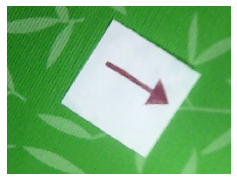

58.016790220178294


In [18]:
img = cv2.imread('../data/imgs/arrow/vlcsnap-2020-10-21-18h01m49s487.png', cv2.IMREAD_COLOR)
plt.imshow(img)
plt.axis('off')
plt.show()
print(find_distance(img))

# Работа с видео

In [19]:
def bird_eye_transform(img, show=False):
    low_th  = (190, 190, 190)
    high_th = (255, 255, 255)

    approx, mask, contour_marked  = find_contour(img, low_th, high_th)
    warped = four_point_transform(img, np.asarray(approx)[:, 0, :])

    if show:
        plt.imshow(img)
        # plt.axis('off')
        plt.show()

        plt.imshow(warped)
        # plt.axis('off')
        plt.show()
    
    return warped, mask, contour_marked

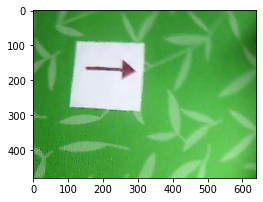

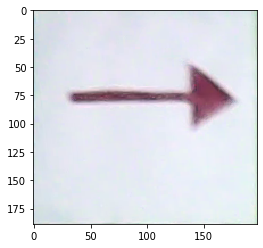

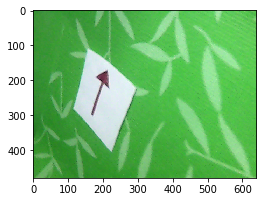

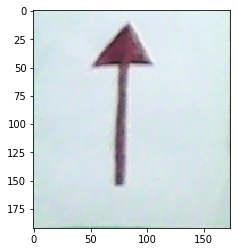

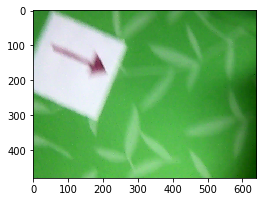

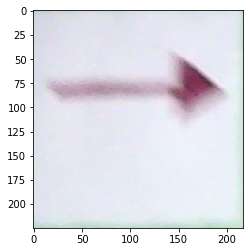

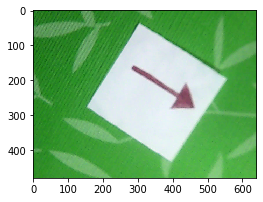

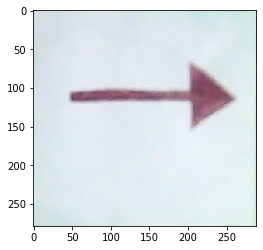

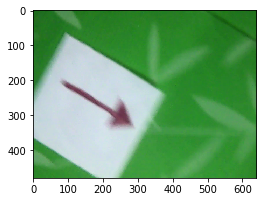

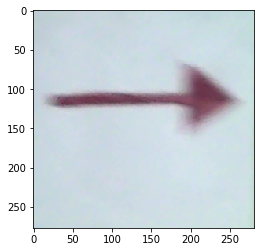

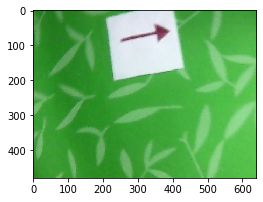

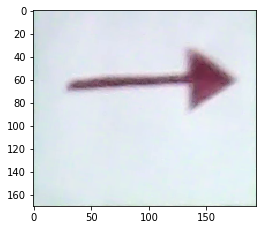

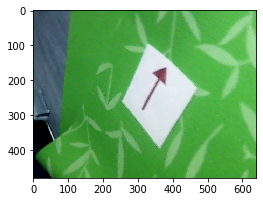

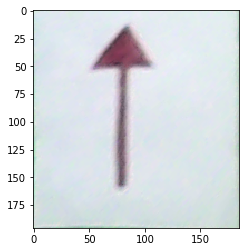

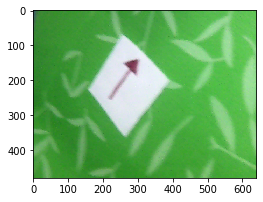

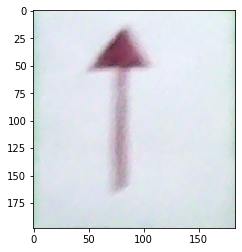

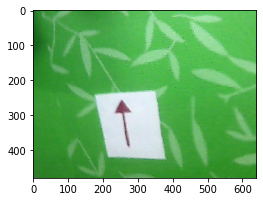

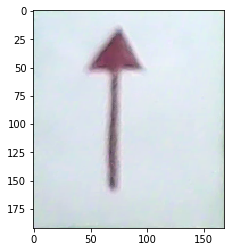

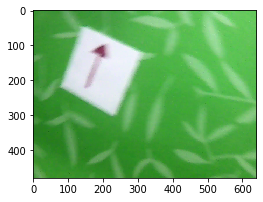

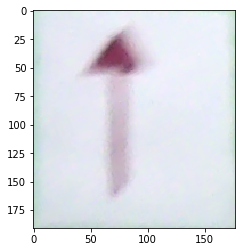

In [14]:
for f in images:
    img = cv2.imread(f)
    bird_eye_transform(img, show=True)

In [45]:
cap = cv2.VideoCapture('../data/imgs/arrow/vid.mov')
# cap = cv2.VideoCapture(0)
width = 320
height = 240
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('../data/imgs/arrow/output.avi', fourcc, 20.0, (2*width, 2*height))

while(cap.isOpened()):
    ret, frame = cap.read()
    if ret:
        orig_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame, mask, contour = bird_eye_transform(frame)
        
        orig_rgb = cv2.resize(orig_rgb, (width, height), interpolation=cv2.INTER_AREA)
        frame = cv2.resize(frame, (width, height), interpolation=cv2.INTER_AREA)
        mask = cv2.resize(mask, (width, height), interpolation=cv2.INTER_AREA)
        contour = cv2.resize(contour, (width, height), interpolation=cv2.INTER_AREA)
        
        mask_img = np.ones(frame.shape, dtype="float32")*255
        mask_res = cv2.bitwise_and(mask_img, mask_img, mask=mask)
        mask_res = np.uint8(mask_res)
        
        row1 = np.concatenate((orig_rgb, mask_res), axis=1)
        row2 = np.concatenate((contour, frame), axis=1)
        res = np.concatenate((row1, row2), axis=0)
        
        cv2.imshow('result', res)
        out.write(res)
        
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
        
    else:
        break

cap.release()
out.release()
cv2.destroyAllWindows()